## Module 4: *(Template)*

**RENAME THE FILE TO INCLUDE YOUR COMPANY, GROUP NUMBER, AND LAST NAMES**

**E.G. KAMEN1_GROVES_MODULE_4.IPYNB**

## Team Members:
Ryan Sloan and Mahsood Ali
## Project Title:
Modeling COVID-19 Transmission Dynamics in Italy Using SIR Estimates



## Project Goal:
How did the susceptible, infectious, and recovered populations change over time during Italy’s first COVID-19 wave, and what does this tell us about the spread and containment of the disease?

## Disease Background:

Using your assigned disease, fill in the following bullet points.

* Prevalence & incidence: Overall, Italy has had 143,626 confirmed total cases and 18,279 deaths to date. 
https://pmc.ncbi.nlm.nih.gov/articles/PMC7270641/

* Economic burden: 
Over time, COVID caused a massive economic contraction, resulting in an estimated $8–$14 trillion USD loss in global output. When combined with medical care costs and other indirect expenses, the total burden amounted to roughly 9–10% of global GDP. The crisis pushed over 100 million people into poverty as businesses shut down and quarantines were implemented. In response, governments across the world deployed more than $11 trillion USD in relief measures and economic stimulus, which increaed the global debt further. 

https://www.imf.org/external/pubs/ft/ar/2020/eng/spotlight/covid-19/
https://www.un.org/en/desa/covid-19-slash-global-economic-output-85-trillion-over-next-two-years?
https://www.imf.org/en/-/media/files/publications/wp/2022/english/wpiea2022261-print-pdf.pdf?
https://systematicreviewsjournal.biomedcentral.com/articles/10.1186/s13643-024-02476-6?

* Risk factors (genetic, lifestyle) & Societal determinants: Risk factors for COVID-19 include pre-existing health conditions such as cancer, cerebrovascular disease, chronic lung diseases, heart conditions, diabetes, obesity, sickle cell disease, and immunocompromised or weakened immune system. Additionally, social determinants such as congregate living, and systemic health inequities 
https://www.cdc.gov/covid/risk-factors/index.html#:~:text=This%20list%20is%20not%20in%20order%20of,Diabetes%20*%20Asthma%20*%20Sickle%20cell%20disease
https://www.mayoclinic.org/diseases-conditions/coronavirus/symptoms-causes/syc-20479963#:~:text=Smoking%20increases%20the%20risk%20of%20serious%20COVID%2D19,may%20have%20a%20higher%20risk%20as%20well.

* Symptoms
* Diagnosis
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology)

In [30]:
import pandas as pd
import numpy as np

def convert_cumulative_to_SIR(df, 
                              date_col='date',
                              cumulative_col='cumulative_cases',
                              population=None,
                              infectious_period=8,
                              recovered_col=None,
                              new_case_col='new_cases',
                              I_col='I_est',
                              R_col='R_est',
                              S_col='S_est'):
    """
    Convert cumulative reported cases into S, I, R estimates for SIR modeling.

    Steps:
        new_cases = diff(cumulative_cases)
        I_est = rolling sum(new_cases, window=infectious_period)
        R_est = cumulative_cases shifted by infectious_period
                OR a provided recovered_col
        S_est = population - I_est - R_est   (only if population is given)

    Returns:
        df (copy) with added: new_cases, I_est, R_est, S_est
    """
    df = df.copy()

    # Ensure sorted by date if present
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).reset_index(drop=True)

    # Safety check
    if cumulative_col not in df.columns:
        raise ValueError(f"Column '{cumulative_col}' not found in dataframe.")

    # 1. New cases
    df[new_case_col] = df[cumulative_col].diff().fillna(df[cumulative_col].iloc[0])
    df[new_case_col] = df[new_case_col].clip(lower=0)

    # 2. I(t) = active infections ≈ rolling sum of new cases
    df[I_col] = df[new_case_col].rolling(
        window=infectious_period, min_periods=1
    ).sum()

    # 3. R(t) — removed
    if recovered_col is not None and recovered_col in df.columns:
        df[R_col] = df[recovered_col].fillna(0)
    else:
        df[R_col] = df[cumulative_col].shift(infectious_period).fillna(0)

    # 4. S(t) if population known
    if population:
        df[S_col] = population - df[I_col] - df[R_col]
        df[S_col] = df[S_col].clip(lower=0)  # safety
    else:
        df[S_col] = np.nan  # population unknown → S undefined

    return df


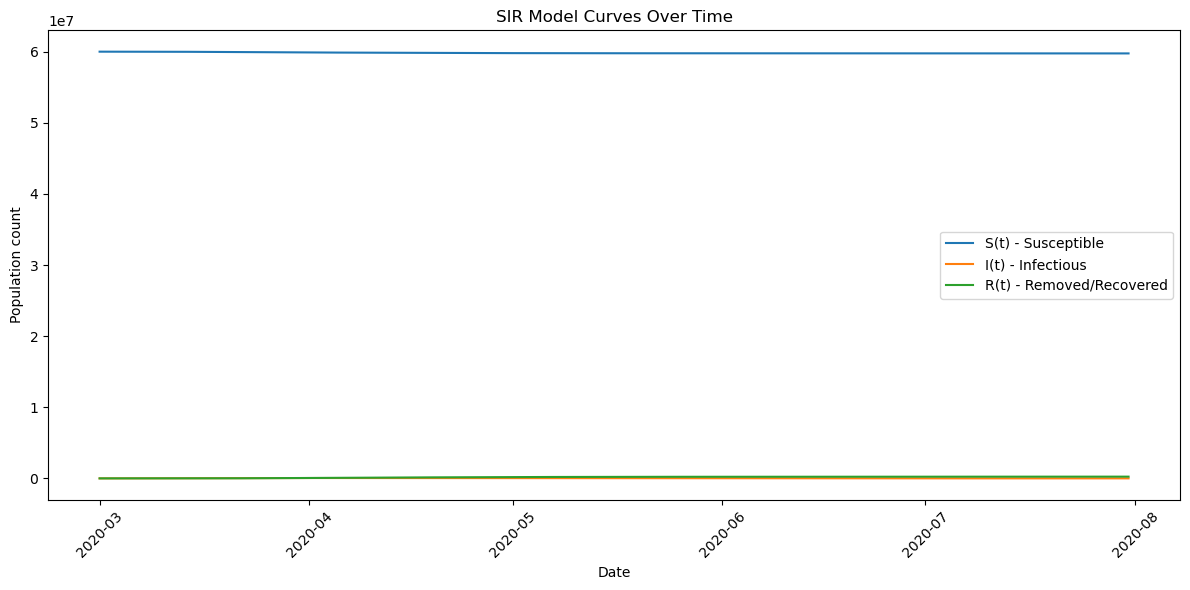

In [31]:
df_raw = pd.read_csv("covid_italy_data_march_july_2020_cumulative.csv")

df_SIR = convert_cumulative_to_SIR(
    df_raw,
    date_col='date',
    cumulative_col='confirmed_cases',
    population=60_000_000,
    infectious_period=10,      # Option B
    new_case_col='new_cases',
    I_col='I',
    R_col='R',
    S_col='S'
)

df_SIR.head()


import matplotlib.pyplot as plt

def plot_SIR(df, date_col='date', S_col='S', I_col='I', R_col='R'):
    """
    Plot S(t), I(t), R(t) over time on the same graph.
    """
    plt.figure(figsize=(12, 6))

    plt.plot(df[date_col], df[S_col], label='S(t) - Susceptible')
    plt.plot(df[date_col], df[I_col], label='I(t) - Infectious')
    plt.plot(df[date_col], df[R_col], label='R(t) - Removed/Recovered')

    plt.xlabel("Date")
    plt.ylabel("Population count")
    plt.title("SIR Model Curves Over Time")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_SIR(df_SIR)

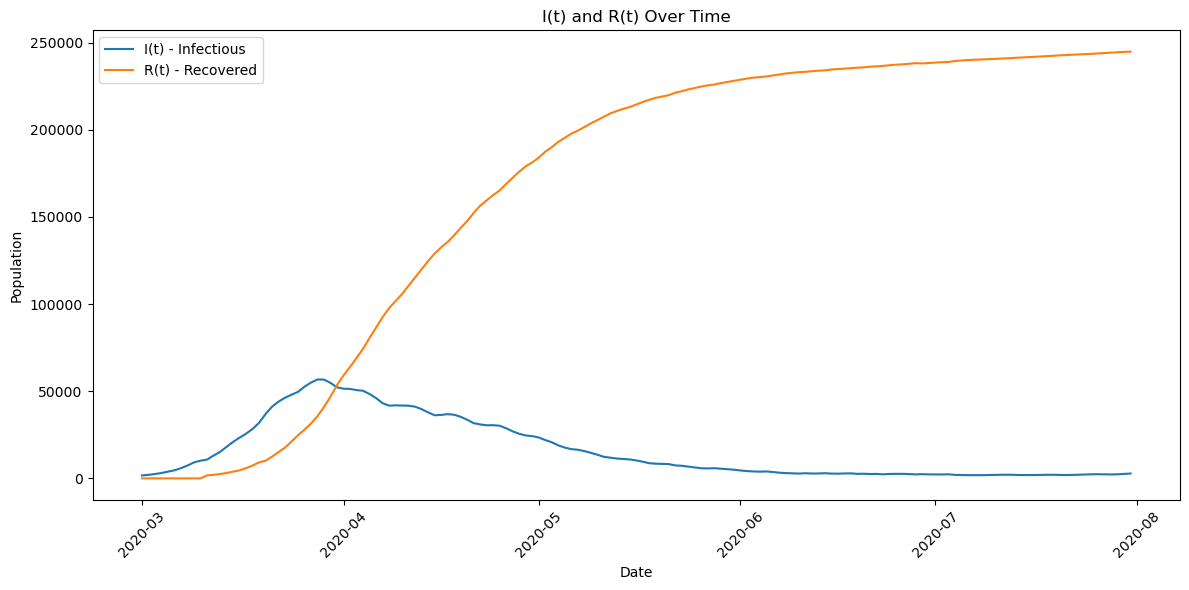

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df_SIR['date'], df_SIR['I'], label='I(t) - Infectious')
plt.plot(df_SIR['date'], df_SIR['R'], label='R(t) - Recovered')
plt.xlabel("Date")
plt.ylabel("Population")
plt.title("I(t) and R(t) Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Dataset: 

*(Describe the data set you will analyze. Cite the source(s) of the data. Describe how the data was collected -- What techniques were used? What units are the data measured in? Etc.)*

## Data Analyis: 

### Methods

*IN A SUMMARY, DESCRIBE THE METHODS YOU USED TO ANALYZE AND MODEL THE DATA.*


### Analysis
*(Describe how you analyzed the data. This is where you should intersperse your Python code so that anyone reading this can run your code to perform the analysis that you did, generate your figures, etc.)*

In [6]:
## PYTHON CODE TO BUILD AND FIT AN SIR MODEL GOES HERE. INTERSPERSE COMMENTS (IN MARKDOWN) TO EXPLAIN EACH STEP.

## Verify and validate your analysis: 

*(Describe how you checked to see that your analysis gave you an answer that you believe (verify). Describe how your determined if your analysis gave you an answer that is supported by other evidence (e.g., a published paper).*

## Conclusions and Ethical Implications: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## NOTES FROM YOUR TEAM: 
(11/22/25)- We looked at the background of covid both generally and in depth of italy. We have upload the data set and understand certain formattting of the general dataset. 

## QUESTIONS FOR YOUR TA: 
(11/22/25)-currently we are still beginning the process of analyizing our data and understanding how it is precieved. we have no questions at this time